Initialize

In [1]:
import gzip
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import struct
import keras.utils.np_utils

# Wyświetlanie w notebooku
%matplotlib inline 

labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
n_cat = len(labels)

Ładujemy dane

In [2]:
def read_emnist(file):
    with gzip.open(file, 'rb') as f:
        print("Plik: ", file)
        z, dtype, dim = struct.unpack('>HBB', f.read(4)) # Odczyt big-endian
        print("Wymiar: ", dim)
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dim)) # Rozmiar każdego wymiaru
        print("Kształt: ", shape)
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape) # Zwraca dane jako przekształcony ciąg numpy

In [3]:
def load_emnist():
    load_train_X = read_emnist(str(pathlib.Path().resolve()) + '/Dane/emnist-balanced-train-images-idx3-ubyte.gz')
    load_train_Y = read_emnist(str(pathlib.Path().resolve()) + '/Dane/emnist-balanced-train-labels-idx1-ubyte.gz')
    load_test_X = read_emnist(str(pathlib.Path().resolve()) + '/Dane/emnist-balanced-test-images-idx3-ubyte.gz')
    load_test_Y = read_emnist(str(pathlib.Path().resolve()) + '/Dane/emnist-balanced-test-labels-idx1-ubyte.gz')

    return (load_train_X, load_train_Y, load_test_X, load_test_Y)

In [4]:
raw_train_X, raw_train_Y, raw_test_X, raw_test_Y = load_emnist()

Plik:  C:\Users\Kacper\OneDrive\Politechnika\sem8\python\projekt/Dane/emnist-balanced-train-images-idx3-ubyte.gz
Wymiar:  3
Kształt:  (112800, 28, 28)
Plik:  C:\Users\Kacper\OneDrive\Politechnika\sem8\python\projekt/Dane/emnist-balanced-train-labels-idx1-ubyte.gz
Wymiar:  1
Kształt:  (112800,)
Plik:  C:\Users\Kacper\OneDrive\Politechnika\sem8\python\projekt/Dane/emnist-balanced-test-images-idx3-ubyte.gz
Wymiar:  3
Kształt:  (18800, 28, 28)
Plik:  C:\Users\Kacper\OneDrive\Politechnika\sem8\python\projekt/Dane/emnist-balanced-test-labels-idx1-ubyte.gz
Wymiar:  1
Kształt:  (18800,)


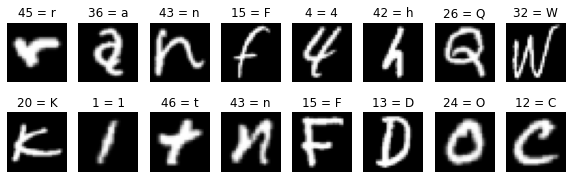

In [10]:
plt.figure(figsize=(10, 4))
for i in range(16):
    plt.subplot(2, 8, i + 1)
    plt.imshow(raw_train_X[i].T, cmap='gray') # Dane emnist są transponowane
    title = '%d = %s' % (raw_train_Y[i], labels[raw_train_Y[i]])
    plt.title(title)
    plt.axis('off')
plt.subplots_adjust(hspace = -.3)
plt.show()

Prepare Data

Do trenowania używamy po 30 zdjęć dla każdego znaku. Za długo trenuje, żeby dać więcej.

In [11]:
count = np.zeros(47)
train_X = np.empty((0, 28, 28))
train_Y = np.empty((0), dtype='int64')
i = 0
while(count.all() < 10 and i < 112800):
    if(count[int(raw_train_Y[i])] < 10):
        train_X = np.append(train_X, [raw_train_X[i]], axis=0)
        train_Y = np.append(train_Y, [raw_train_Y[i]], axis=0)
        count[int(raw_train_Y[i])] += 1
        #print(count)
    i += 1

In [12]:
count = np.zeros(47)
test_X = np.empty((0, 28, 28))
test_Y = np.empty((0), dtype='int64')
i = 0
while(count.all() < 10 and i < 18800):
    if(count[int(raw_test_Y[i])] < 10):
        test_X = np.append(test_X, [raw_test_X[i]], axis=0)
        test_Y = np.append(test_Y, [raw_test_Y[i]], axis=0)
        count[int(raw_test_Y[i])] += 1
        #print(count)
    i += 1

Przekształcenie i normalizacja

In [8]:
img_height = raw_train_X[0].shape[0]
img_width = raw_train_X[0].shape[1]
input_shape = img_height*img_width

print('Surowy rozmiar: ', train_X.shape)

Surowy rozmiar:  (470, 28, 28)


In [9]:
train_X = train_X.reshape(len(train_X), input_shape)
test_X = test_X.reshape(len(test_X), input_shape)
print('Po przekształceniu: ', train_X.shape)

Po przekształceniu:  (470, 784)


In [10]:
# Konwersja z uint8 na float32
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

train_X /= 255
test_X /= 255

In [11]:
"""print(train_X.shape)
train_X = train_X[0:3000, 0:]
test_X = test_X[0:300, 0:]
train_Y = raw_train_Y[0:3000]
test_Y = raw_test_Y[0:300]
print(train_X.shape)"""

'print(train_X.shape)\ntrain_X = train_X[0:3000, 0:]\ntest_X = test_X[0:300, 0:]\ntrain_Y = raw_train_Y[0:3000]\ntest_Y = raw_test_Y[0:300]\nprint(train_X.shape)'

Już przekształcone dane

In [12]:
#np.save("Dane/emnist-balanced-train-30-X.npy", train_X)
#np.save("Dane/emnist-balanced-train-30-Y.npy", train_Y)
#np.save("Dane/emnist-balanced-test-10-X.npy", test_X)
#np.save("Dane/emnist-balanced-test-10-Y.npy", test_Y)

In [13]:
#train_X = np.load("Dane/emnist-balanced-train-30-X.npy")
#train_Y = np.load("Dane/emnist-balanced-train-30-Y.npy")
#test_X = np.load("Dane/emnist-balanced-test-10-X.npy")
#test_Y = np.load("Dane/emnist-balanced-test-10-Y.npy")
#print(train_X.shape)

Model RBF

In [14]:
#Euklidesowa odlełość. Pierwiastek z sumy kwadratów odległości.
def euc_dist(x, y):
    d = 0
    for i in range(len(x)):
        d += (x[i] - y[i])**2
    return np.sqrt(d)

In [15]:
def kmeans(X, k):
    #Wybieramy k losowych elementów jako początki centroid
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]
    
    #Funkcja ma 100 powtórzeń na znalezienie optymalnego rozkładu
    for i in range(100):
        #Lista [[][]...[]] przynależnych elementów do centroid
        clusters = [[] for _ in range(len(centroids))] 
        
        for x_i, x in enumerate(X):  #Przejdź przez każdy element
            distances_list = []
            for c_i, c in enumerate(centroids): #Przejdz przez centroidy
                distances_list.append(euc_dist(c, x)) #Odległość centroidy od zdjęcia

            #Element przypisywany jest do najbliższego klastra / centroidy
            clusters[int(np.argmin(distances_list))].append(x)

        centroids_old = centroids.copy() # Kopiowanie do porównania
        
        #Kalkuluje średnią pozycję centroid na podstawie zdjęć przypisanych do klastra
        centroids = [np.mean(c, axis=0) for c in clusters]

        diff = np.abs(np.sum(centroids_old) - np.sum(centroids)) # Porównanie z poprzednią iteracją

        if diff == 0: #Jeśli jest optymalne rozmieszczenie to zakończ
            break
    
    return centroids # Zwraca centroidy

In [16]:
class RBF:

    def __init__(self, X, Y, TX, TY, k):
        self.TrX = X #Zdjęcia do trenowania
        self.TrY = Y #Klasy zdjęć do trenowania
        self.TeX = TX #Zdjęcia do testowania
        self.TeY = TY #Klasy zdjęć do testowania
        self.k = k #Ilość centroid / neuronów

    #Zwraca wartość funkcji radialnej
    def get_rbf(self, x, c, B):
        distance = euc_dist(x, c) #Odległość elementu od centroida
        return np.exp(-(distance**2) / (2*B**2)) #Funckja radialna

    #Zwraca listę rbf dla podanych elementów
    def get_rbf_matrix(self, X, centroids, B):
        #Dla każdego elementu zwraca wartość rbf od wszystkich centroid
        return np.array([[self.get_rbf(x, c, B) for c in centroids] for x in X])
    
    #Wyznacza centroidy dla elementów
    def find_kmeans(self):
        self.centroids = kmeans(self.TrX, self.k)

    #Wyznaczanie wag
    def fit(self, B):
        #Zwraca macierz rbf dla elementów trenujących
        RBF_X = self.get_rbf_matrix(self.TrX, self.centroids, B) 
        #Oblicza wagi na podstawie listy rbf i odpowiadających jej elementom klas
        self.W = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ keras.utils.np_utils.to_categorical(self.TrY) 

    #Testowanie sieci
    def test(self, B):
        #Zwraca macierz rbf dla elementów testowych
        RBF_TX = self.get_rbf_matrix(self.TeX, self.centroids, B) 
        self.PredTeY = RBF_TX @ self.W #Mnożenie rbf z wagami
        
        #Wybiera neurony z największą sumą jako wynik
        self.PredTeY = np.array([np.argmax(x) for x in self.PredTeY]) 

        #Oblicza różnicę między klasami przewidzianymi a prawdziwymi
        diff = self.PredTeY - self.TeY 
        #Oblicza stosunek prawidłowych trafień
        self.Accuracy = len(np.where(diff == 0)[0]) / len(diff)
        print('Accuracy: ', self.Accuracy)

        #Tworzenie tabeli lasyfikacji
        self.accuracy_table = np.zeros((47,47))
        #Przechodzi przez wszystkie elementy testujące
        for i, y in enumerate(self.TeY):
            #Zwiększa numerację w odpowiednim miejscu tabeli
            self.accuracy_table[y, self.PredTeY[i]] += 1
            #Dodaje element po drugiej stronie dla symetryczności
            if y != self.PredTeY[i]:
                self.accuracy_table[self.PredTeY[i], y] += 1

Train Model

In [17]:
RBFNN = RBF(train_X, train_Y, test_X, test_Y, 10)

In [18]:
RBFNN.find_kmeans()

In [8]:
#np.save('Output/30/centroids 10 - 30.npy', RBFNN.centroids)

In [9]:
#RBFNN.centroids = np.load('Output/30/centroids 10 - 30.npy')

In [18]:
RBFNN.fit(6)

In [19]:
RBFNN.test(6)

Accuracy:  0.11914893617021277


In [ ]:
np.save('Output/30/weights 10 - 30 v3 B6 acc' + str(RBFNN.Accuracy) + ".npy", RBFNN.W)
np.save('Output/30/acc_table 10 - 30 v3 B6' + ".npy", RBFNN.accuracy_table)

Inspect Model

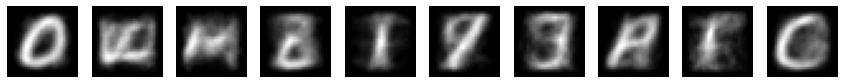

In [19]:
cen = np.array(RBFNN.centroids)

cen = cen.reshape(RBFNN.k, 28, 28)

plt.figure(figsize=(30, 8))
for i in range(min(RBFNN.k,80)):
    plt.subplot(4, 20, i + 1)
    plt.imshow(cen[i].T, cmap='gray') # Dane emnist są transponowane
    plt.axis('off')
plt.subplots_adjust(hspace = -.3)
plt.show()